In [ ]:
import pandas as pd
import os
import numpy as np
import xlrd
import copy
import datetime
import glob
import time

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [ ]:
plt.rcParams["font.family"] = "Trebuchet MS"
mpl.rcParams["figure.dpi"] = 250

### Import data


In [ ]:
df_uk = pd.read_csv('elexon_all_uk.csv', sep=',', parse_dates=True, index_col=[0], engine='python')
df_uk = df_uk.rename(columns={'Unnamed: 0': 'timeblock'})
df_uk.index.dtype # '<M8[ns]'is time series

dtype('<M8[ns]')

In [ ]:
df_uk.wind_elexon = pd.to_numeric(df_uk.wind_elexon, errors='coerce') # wind_elexon contains obejcts


In [ ]:
df_uk.shape

(52566, 12)

### Add columns

In [ ]:
# Create new column y: intraday price - imbalance price >= 0  then denote as 1; intraday price - imbalance price <0 then denote as 0
def create_y_column(row): # Alternative: where method
    if row['intraday_price'] < row['imbalance_price']: # Learning: Use lambda function
        val = 0
    else:
        val = 1

    return val

# Add y 
df_uk['y'] = df_uk.apply(create_y_column, axis=1)

In [ ]:
# Add error columns
df_uk_error = df_uk.copy()

df_uk_error['wind_entsoe_error'] = df_uk_error['wind_for_entsoe'] - df_uk_error['wind_entsoe']
df_uk_error['wind_elexon_error'] = df_uk_error['wind_for_elexon'] - df_uk_error['wind_elexon']
df_uk_error['solar_entsoe_error'] = df_uk_error['solar_for_entsoe'] - df_uk_error['solar_entsoe']

In [ ]:
df_uk = df_uk_error

In [ ]:
# Add weekday/weekend dummies
df_uk['weekday'] = ((pd.DatetimeIndex(df_uk.index).dayofweek) // 5 == 1).astype(float)

In [ ]:
# Add consin sin
df_uk['timestamps'] = df_uk.index
dateofyr = df_uk.timestamps.dt.dayofyear
df_uk['timestamps_trigonometric'] = np.sin(dateofyr*2*np.pi/365)
df_uk = df_uk.drop(columns='timestamps')

In [ ]:
df_uk.columns

Index(['demand_ITSDO', 'demand_INDO', 'wind_elexon', 'wind_for_elexon',
       'imbalance_price', 'imbalance_volume', 'solar_entsoe', 'wind_entsoe',
       'wind_for_entsoe', 'solar_for_entsoe', 'intraday_volume',
       'intraday_price', 'y', 'wind_entsoe_error', 'wind_elexon_error',
       'solar_entsoe_error', 'weekday', 'timestamps_trigonometric'],
      dtype='object')

##### Data prep (Full variables)

In [ ]:
df_uk_rf = df_uk.copy()
df_uk_rf.head()

,demand_ITSDO,demand_INDO,wind_elexon,wind_for_elexon,imbalance_price,imbalance_volume,solar_entsoe,wind_entsoe,wind_for_entsoe,solar_for_entsoe,intraday_volume,intraday_price,y,wind_entsoe_error,wind_elexon_error,solar_entsoe_error,weekday,timestamps_trigonometric
2017-01-01 00:00:00,27949.0,27239.0,3923.166667,2423.0,40.00000,-251.8659,0.0,4891.0,3140.0,0.0,505.00,44.90,1,-1751.0,-1500.166667,0.0,1.0,0.017213
2017-01-01 00:30:00,28435.0,27814.0,3657.500000,2423.0,46.86500,26.7183,0.0,4595.0,3140.0,0.0,559.15,47.13,1,-1455.0,-1234.500000,0.0,1.0,0.017213
2017-01-01 01:00:00,28165.0,27453.0,3925.000000,2528.5,40.24737,-93.0661,0.0,4686.0,3242.5,0.0,649.35,45.62,1,-1443.5,-1396.500000,0.0,1.0,0.017213
2017-01-01 01:30:00,27707.0,26312.0,4393.166667,2528.5,40.05000,-403.2791,0.0,5439.0,3242.5,0.0,712.65,44.05,1,-2196.5,-1864.666667,0.0,1.0,0.017213
2017-01-01 02:00:00,27449.0,25289.0,4417.666667,2538.0,40.01602,-447.9751,0.0,5400.0,3272.5,0.0,599.15,44.83,1,-2127.5,-1879.666667,0.0,1.0,0.017213


In [ ]:
# Set hyperparameters
# Create time lag columns
l = 336 # l is lag

In [ ]:
# Create t-2, t-3... columns

###
p = 6 # for lag 0.5 hr: 2 # for lag 2 hr: 6

lags = range(p, p+l)  # 5 lags # 10 lags # 48 lags

df_uk_rf = df_uk_rf.assign(**{
    '{} (t-{})'.format(col, t): df_uk_rf[col].shift(t)
    for t in lags
    for col in df_uk_rf[['demand_INDO','demand_ITSDO']]
})

###
p = 8 # for lag 0.5 hr: 4 # for lag 2 hr: 8

lags = range(p, p+l) 

df_uk_rf = df_uk_rf.assign(**{
    '{} (t-{})'.format(col, t): df_uk_rf[col].shift(t)
    for t in lags
    for col in df_uk_rf[['wind_entsoe', 'solar_entsoe', 'wind_elexon', 'wind_entsoe_error','solar_entsoe_error', 'wind_elexon_error']]
})

###
p = 0 

lags = range(p, p+l) 

df_uk_rf = df_uk_rf.assign(**{
    '{} (t-{})'.format(col, t): df_uk_rf[col].shift(t)
    for t in lags
    for col in df_uk_rf[['wind_for_entsoe','solar_for_entsoe', 'wind_for_elexon', 'timestamps_trigonometric']]
})


###
p = 7  # for lag 0.5 hr: 3 # for lag 2 hr: 7

lags = range(p, p+l) 

df_uk_rf = df_uk_rf.assign(**{
    '{} (t-{})'.format(col, t): df_uk_rf[col].shift(t)
    for t in lags
    for col in df_uk_rf[['imbalance_price','imbalance_volume', 'intraday_volume', 'intraday_price']]
})
df_uk_rf.head()

,demand_ITSDO,demand_INDO,wind_elexon,wind_for_elexon,imbalance_price,imbalance_volume,solar_entsoe,wind_entsoe,wind_for_entsoe,solar_for_entsoe,...,intraday_volume (t-340),intraday_price (t-340),imbalance_price (t-341),imbalance_volume (t-341),intraday_volume (t-341),intraday_price (t-341),imbalance_price (t-342),imbalance_volume (t-342),intraday_volume (t-342),intraday_price (t-342)
2017-01-01 00:00:00,27949.0,27239.0,3923.166667,2423.0,40.00000,-251.8659,0.0,4891.0,3140.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:30:00,28435.0,27814.0,3657.500000,2423.0,46.86500,26.7183,0.0,4595.0,3140.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,28165.0,27453.0,3925.000000,2528.5,40.24737,-93.0661,0.0,4686.0,3242.5,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:30:00,27707.0,26312.0,4393.166667,2528.5,40.05000,-403.2791,0.0,5439.0,3242.5,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,27449.0,25289.0,4417.666667,2538.0,40.01602,-447.9751,0.0,5400.0,3272.5,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_uk_rf = df_uk_rf.reindex(sorted(df_uk_rf.columns), axis=1) # No need to standardize the dataset for RF - Standardization gives the same result in RF
df_uk_rf.head()

,demand_INDO,demand_INDO (t-10),demand_INDO (t-100),demand_INDO (t-101),demand_INDO (t-102),demand_INDO (t-103),demand_INDO (t-104),demand_INDO (t-105),demand_INDO (t-106),demand_INDO (t-107),...,wind_for_entsoe (t-91),wind_for_entsoe (t-92),wind_for_entsoe (t-93),wind_for_entsoe (t-94),wind_for_entsoe (t-95),wind_for_entsoe (t-96),wind_for_entsoe (t-97),wind_for_entsoe (t-98),wind_for_entsoe (t-99),y
2017-01-01 00:00:00,27239.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2017-01-01 00:30:00,27814.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2017-01-01 01:00:00,27453.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2017-01-01 01:30:00,26312.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2017-01-01 02:00:00,25289.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
# Check NA and extract the last value of the na's df
df_na = df_uk_rf[df_uk_rf.isna().any(axis=1)].iloc[[-1]].index.to_frame()
na_end = df_na.iloc[0,0]
na_end

Timestamp('2017-01-08 03:00:00')

In [ ]:
# Start the df with the first row with no NAs
df_uk_rf = df_uk_rf.loc[na_end + datetime.timedelta(minutes=30): , :]
df_uk_rf = df_uk_rf.drop(columns={'wind_for_entsoe','solar_for_entsoe', 'wind_for_elexon', 'timestamps_trigonometric',
                                  'demand_INDO','demand_ITSDO', 
                                  'wind_entsoe','solar_entsoe', 'wind_elexon',
                                  'wind_entsoe_error','solar_entsoe_error','wind_elexon_error',
                                  'imbalance_price','imbalance_volume',
                                  'intraday_volume', 'intraday_price',})
df_uk_rf.head()

,demand_INDO (t-10),demand_INDO (t-100),demand_INDO (t-101),demand_INDO (t-102),demand_INDO (t-103),demand_INDO (t-104),demand_INDO (t-105),demand_INDO (t-106),demand_INDO (t-107),demand_INDO (t-108),...,wind_for_entsoe (t-91),wind_for_entsoe (t-92),wind_for_entsoe (t-93),wind_for_entsoe (t-94),wind_for_entsoe (t-95),wind_for_entsoe (t-96),wind_for_entsoe (t-97),wind_for_entsoe (t-98),wind_for_entsoe (t-99),y
2017-01-08 03:30:00,31362.0,29356.0,30116.0,30472.0,30167.0,30576.0,31848.0,34114.0,36466.0,38838.0,...,2239.0,2218.5,2218.5,2230.0,2230.0,2201.0,2201.0,2146.0,2146.0,1
2017-01-08 04:00:00,29717.0,28860.0,29356.0,30116.0,30472.0,30167.0,30576.0,31848.0,34114.0,36466.0,...,2239.0,2239.0,2218.5,2218.5,2230.0,2230.0,2201.0,2201.0,2146.0,1
2017-01-08 04:30:00,28724.0,28724.0,28860.0,29356.0,30116.0,30472.0,30167.0,30576.0,31848.0,34114.0,...,2312.0,2239.0,2239.0,2218.5,2218.5,2230.0,2230.0,2201.0,2201.0,1
2017-01-08 05:00:00,28374.0,28242.0,28724.0,28860.0,29356.0,30116.0,30472.0,30167.0,30576.0,31848.0,...,2312.0,2312.0,2239.0,2239.0,2218.5,2218.5,2230.0,2230.0,2201.0,1
2017-01-08 05:30:00,28487.0,27745.0,28242.0,28724.0,28860.0,29356.0,30116.0,30472.0,30167.0,30576.0,...,2433.5,2312.0,2312.0,2239.0,2239.0,2218.5,2218.5,2230.0,2230.0,1


In [ ]:
df_uk_rf[df_uk_rf.isnull().any(axis = 1)]


,demand_INDO (t-10),demand_INDO (t-100),demand_INDO (t-101),demand_INDO (t-102),demand_INDO (t-103),demand_INDO (t-104),demand_INDO (t-105),demand_INDO (t-106),demand_INDO (t-107),demand_INDO (t-108),...,wind_for_entsoe (t-91),wind_for_entsoe (t-92),wind_for_entsoe (t-93),wind_for_entsoe (t-94),wind_for_entsoe (t-95),wind_for_entsoe (t-96),wind_for_entsoe (t-97),wind_for_entsoe (t-98),wind_for_entsoe (t-99),y


In [ ]:
# Split the dataset into training, validationand testing set
df_train = df_uk_rf['2017':'2018']
df_vali = df_uk_rf['2019-01':]

In [ ]:
# Shuffle the rows # Need to shuffle before dividing x and y, otherwise they will not match
df_train_shf = df_train.sample(frac=1) 
df_vali_shf = df_vali.sample(frac=1) 

In [ ]:
train = df_train_shf.loc[:, df_train_shf.columns != 'y']
train_labels = np.array(df_train_shf.pop('y')) 

vali = df_vali_shf.loc[:, df_vali_shf.columns != 'y']
vali_labels = np.array(df_vali_shf.pop('y'))

In [ ]:
# Standardize
standardized_train = preprocessing.scale(train)
standardized_vali = preprocessing.scale(vali)

#### Logistic Regression - standardized

In [ ]:
from sklearn.linear_model import LogisticRegression 
t0 = time.time()
classifier = LogisticRegression(random_state = 0)
classifier.fit(train, train_labels) 
t1 = time.time()

total = t1-t0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
logi_pred = classifier.predict(vali)

Baseline: ROC AUC=0.500
Random Forest Model: ROC AUC=0.559


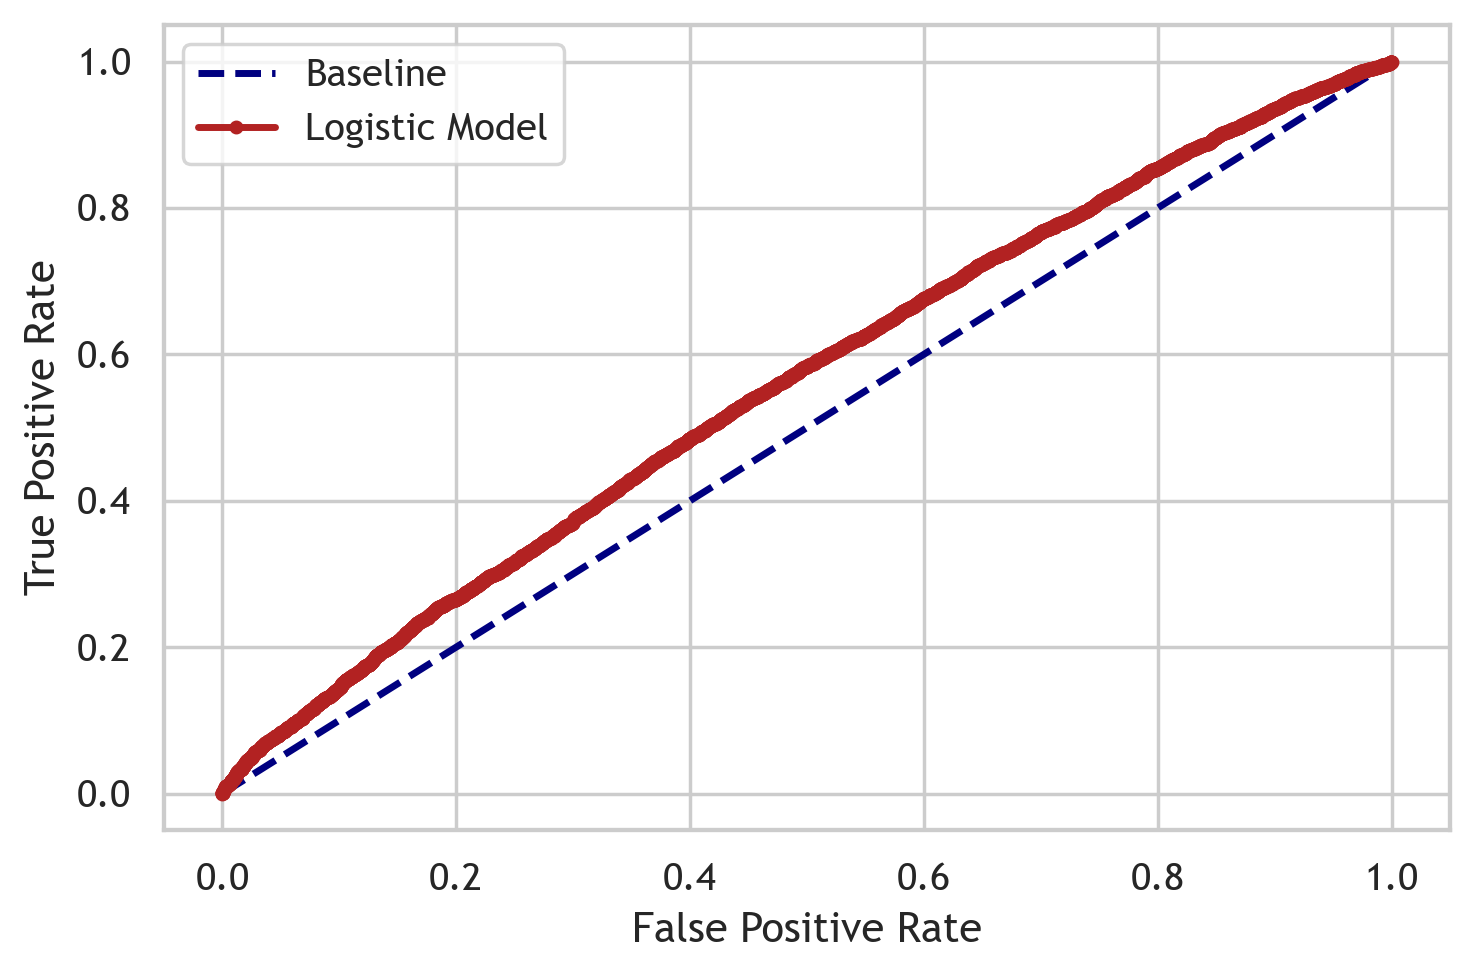

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate a baseline prediction
ns_probs = [0 for _ in range(len(vali_labels))]
lr_probs = classifier.predict_proba(vali)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(vali_labels, ns_probs)
lr_auc = roc_auc_score(vali_labels, lr_probs)
# summarize scores
print('Baseline: ROC AUC=%.3f' % (ns_auc))
print('Random Forest Model: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(vali_labels, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(vali_labels, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline', color = 'navy')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Model', color='firebrick')
for line in plt.gca().lines:
    line.set_linewidth(2)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.tight_layout()

# save the plot
filename = 'roccurve_2hr_logi_norm_lag{}'.format(l) 
plt.savefig(filename+'.png')


# show the plot
plt.show()

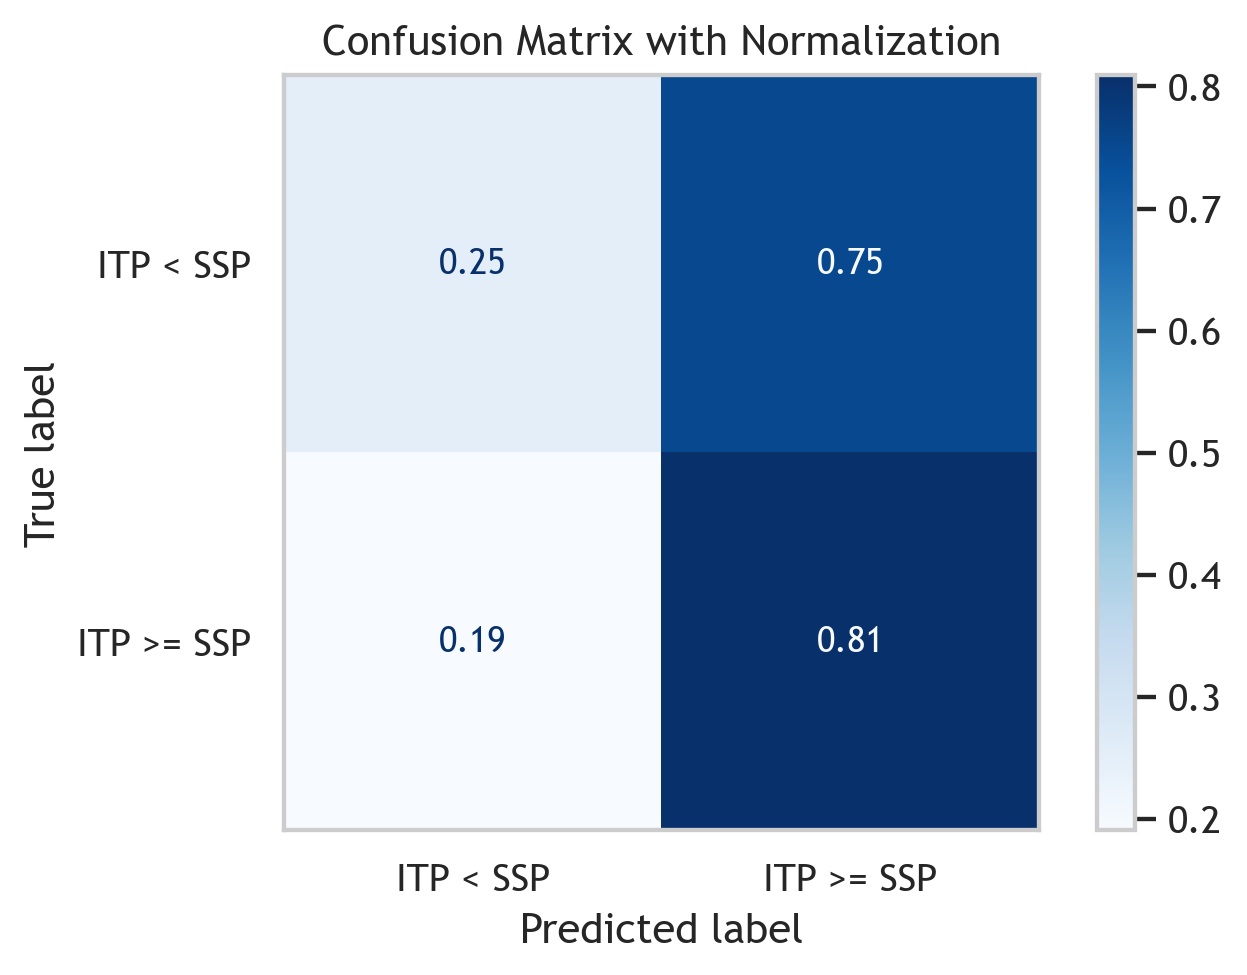

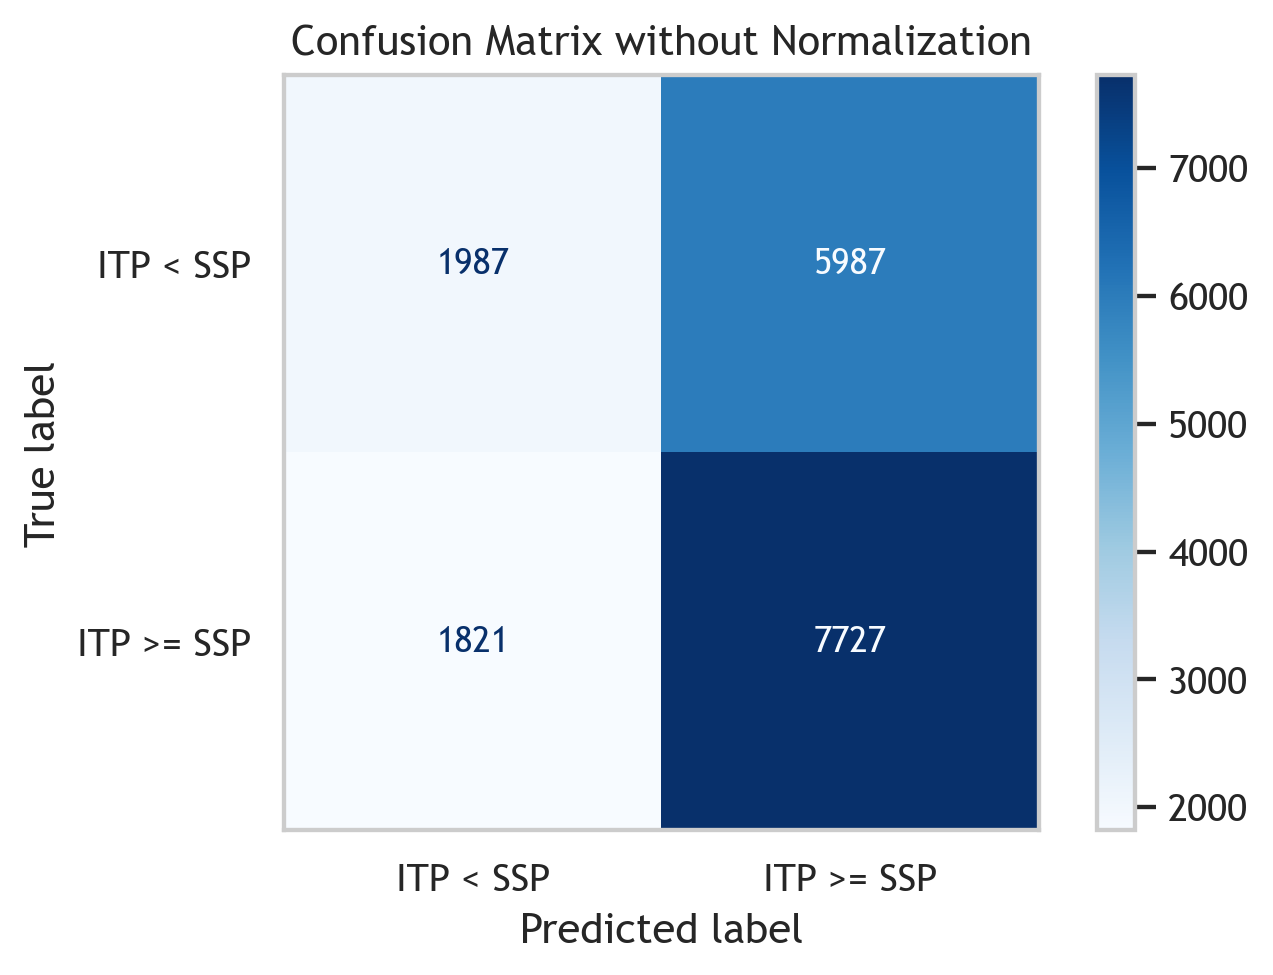

In [ ]:
from sklearn.metrics import plot_confusion_matrix 

disp = plot_confusion_matrix(classifier, vali, vali_labels,
                                 display_labels=['ITP < SSP', 'ITP >= SSP'],
                                 cmap=plt.cm.Blues,
                                 values_format = '.2f',
                                 normalize='true')
plt.grid(False)
disp.ax_.set_title('Confusion Matrix with Normalization')

# save the plot
filename = 'confumatrix_2hr_logi_ori_lag{}'.format(l) 
plt.savefig(filename+'.png')

plt.show()

disp = plot_confusion_matrix(classifier, vali, vali_labels,
                                 display_labels=['ITP < SSP', 'ITP >= SSP'],
                                 cmap=plt.cm.Blues,
                                 values_format = '',
                                 normalize=None)
plt.grid(False)
disp.ax_.set_title('Confusion Matrix without Normalization')

# save the plot
filename = 'confumatrix_2hr_logi_norm_lag{}'.format(l) 
plt.savefig(filename+'.png')

plt.show()

In [ ]:
# summarize scores
print('Run time(s)', str(datetime.timedelta(seconds=total)))
print()
print('Baseline: ROC AUC=%.3f' % (ns_auc))
print('Logistic Model: ROC AUC=%.3f' % (lr_auc))
print()
## Confusion Matrix

from sklearn.metrics import confusion_matrix
print('Confusion matrix', confusion_matrix(vali_labels, logi_pred))

# Accuracy
from sklearn.metrics import accuracy_score
print('Accuracy score',accuracy_score(vali_labels, logi_pred))

# Recall
from sklearn.metrics import recall_score
print('Recall score', recall_score(vali_labels, logi_pred, average=None))

# Precision
from sklearn.metrics import precision_score
print('Precision score',precision_score(vali_labels, logi_pred, average=None))

# F1 score
from sklearn.metrics import f1_score
print('F1 score', f1_score(vali_labels, logi_pred))
# The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. 
# The formula for the F1 score is: F1 = 2 * (precision * recall) / (precision + recall)

Run time(s) 0:00:16.410519

Baseline: ROC AUC=0.500
Logistic Model: ROC AUC=0.559

Confusion matrix [[1987 5987]
 [1821 7727]]
Accuracy score 0.5543887684054332
Recall score [0.24918485 0.80927943]
Precision score [0.52179622 0.56343882]
F1 score 0.664345284154415


#### Logistic Regression - standardized + LASSO

In [ ]:
# X = df_uk_rf.loc[:,df_uk_rf.columns != 'y']
# y = df_uk_rf.pop('y')

In [ ]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(train, train_labels)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

In [ ]:
selected_feat = train.columns[(sel_.get_support())]
print('total features: {}'.format((train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 5377
selected features: 4290
features with coefficients shrank to zero: 324


In [ ]:
# identify and remove unselected features
removed_feats = train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

Index(['imbalance_price (t-107)', 'timestamps_trigonometric (t-0)',
       'timestamps_trigonometric (t-1)', 'timestamps_trigonometric (t-10)',
       'timestamps_trigonometric (t-100)', 'timestamps_trigonometric (t-101)',
       'timestamps_trigonometric (t-102)', 'timestamps_trigonometric (t-103)',
       'timestamps_trigonometric (t-104)', 'timestamps_trigonometric (t-105)',
       ...
       'timestamps_trigonometric (t-90)', 'timestamps_trigonometric (t-91)',
       'timestamps_trigonometric (t-92)', 'timestamps_trigonometric (t-93)',
       'timestamps_trigonometric (t-94)', 'timestamps_trigonometric (t-95)',
       'timestamps_trigonometric (t-96)', 'timestamps_trigonometric (t-97)',
       'timestamps_trigonometric (t-98)', 'timestamps_trigonometric (t-99)'],
      dtype='object', length=324)

In [ ]:
X_train_selected = sel_.transform(train.fillna(0))
X_vali_selected = sel_.transform(vali.fillna(0))
X_train_selected.shape, X_vali_selected.shape

((34701, 4290), (17522, 4290))

In [ ]:
from sklearn.linear_model import LogisticRegression 
t0 = time.time()
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train_selected, train_labels) 
t1 = time.time()

total = t1-t0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
logi_pred = classifier.predict(X_vali_selected)

Baseline: ROC AUC=0.500
Random Forest Model: ROC AUC=0.564


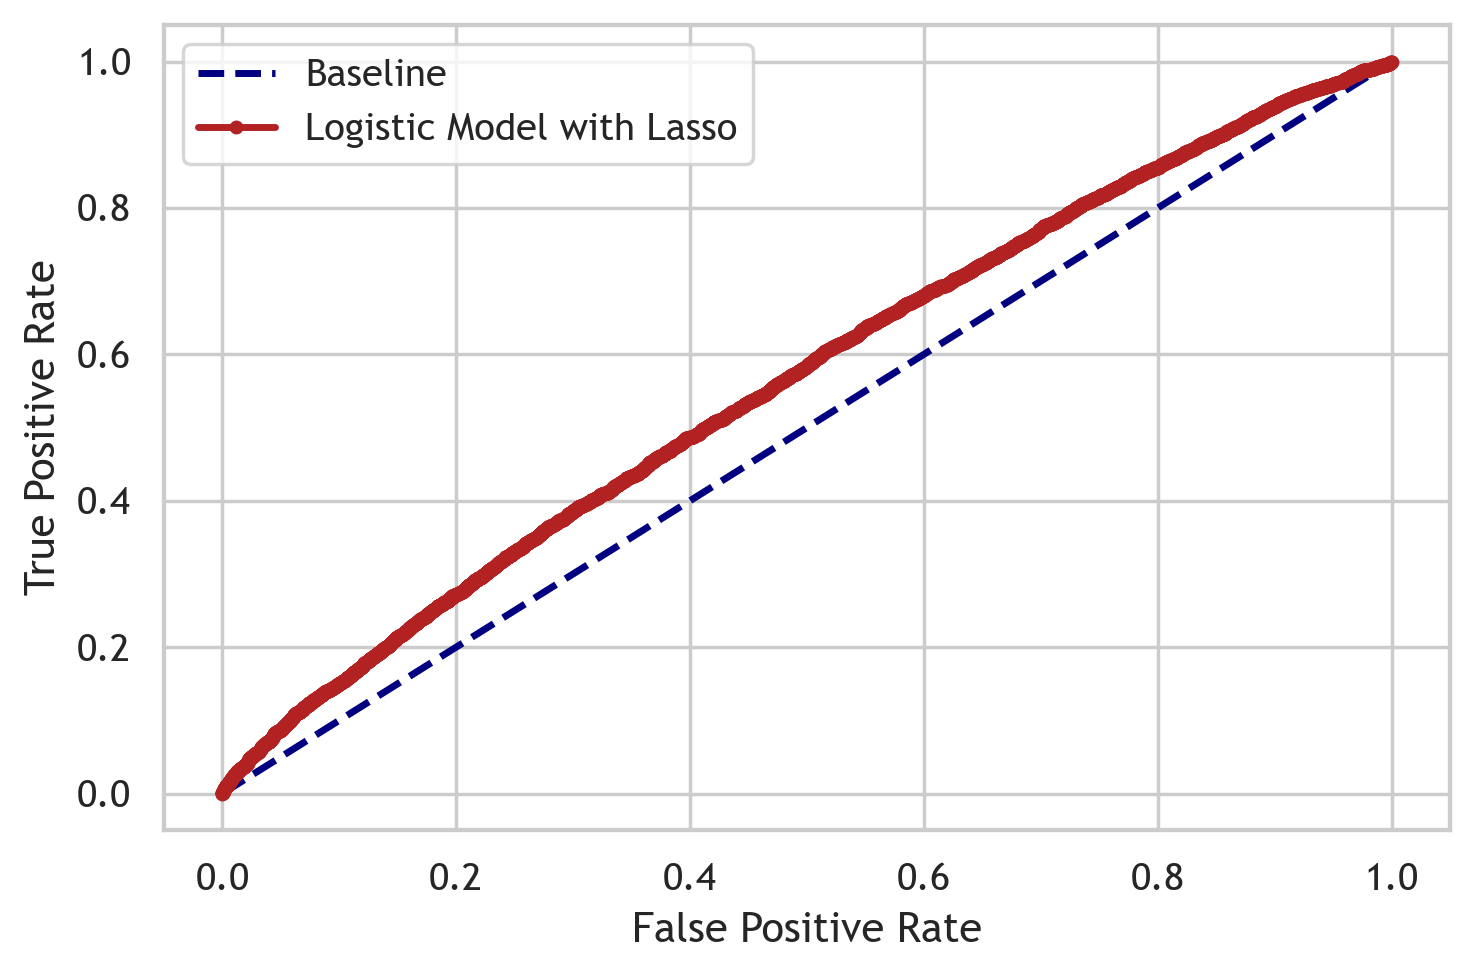

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate a baseline prediction
ns_probs = [0 for _ in range(len(vali_labels))]
lr_probs = classifier.predict_proba(X_vali_selected)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(vali_labels, ns_probs)
lr_auc = roc_auc_score(vali_labels, lr_probs)
# summarize scores
print('Baseline: ROC AUC=%.3f' % (ns_auc))
print('Random Forest Model: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(vali_labels, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(vali_labels, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline', color = 'navy')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Model with Lasso', color='firebrick')
for line in plt.gca().lines:
    line.set_linewidth(2)
    
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.tight_layout()

# save the plot
filename = 'roccurve_2hr_logilasso_norm_lag{}'.format(l) 
plt.savefig(filename+'.png')


# show the plot
plt.show()

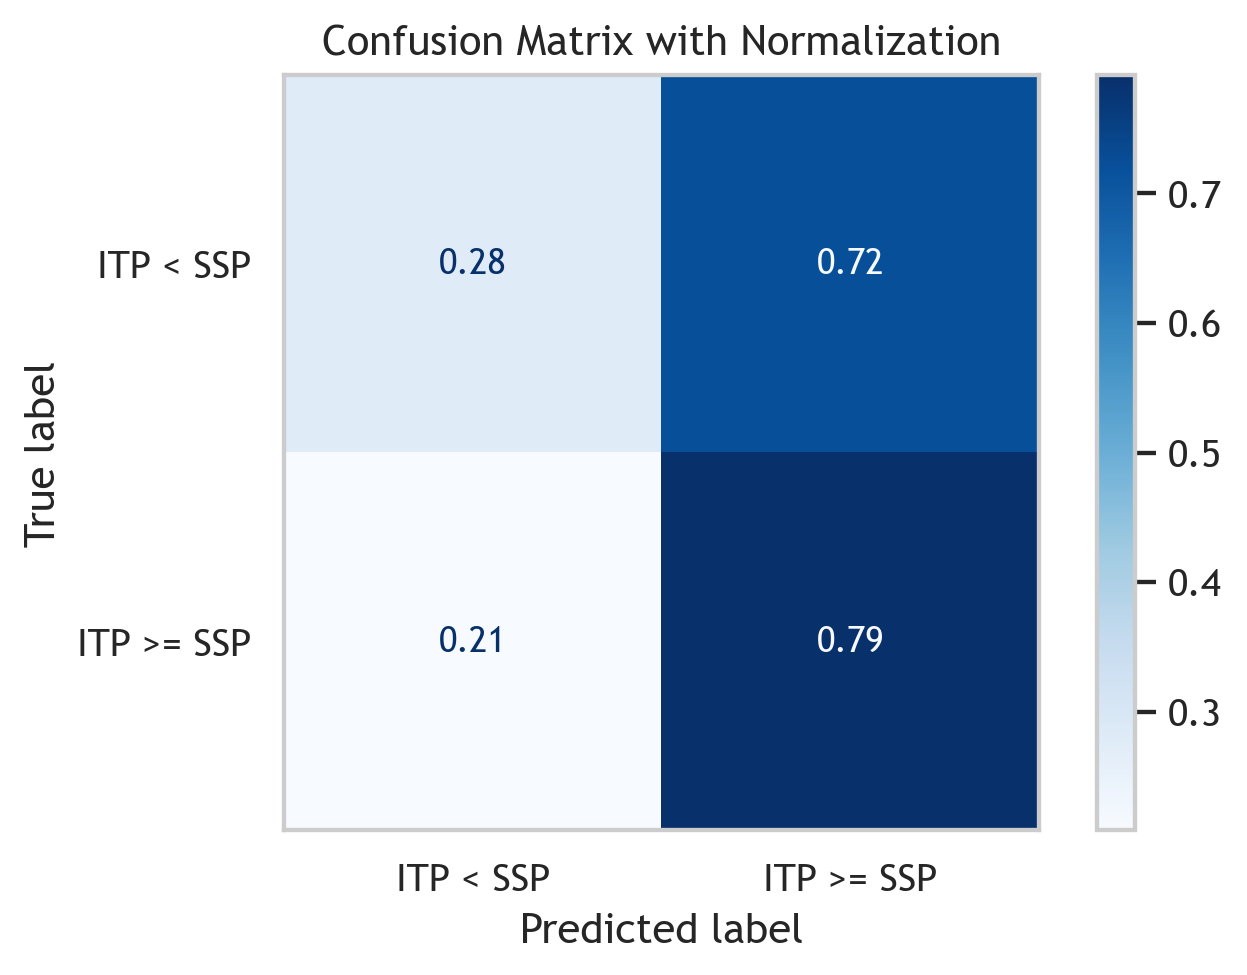

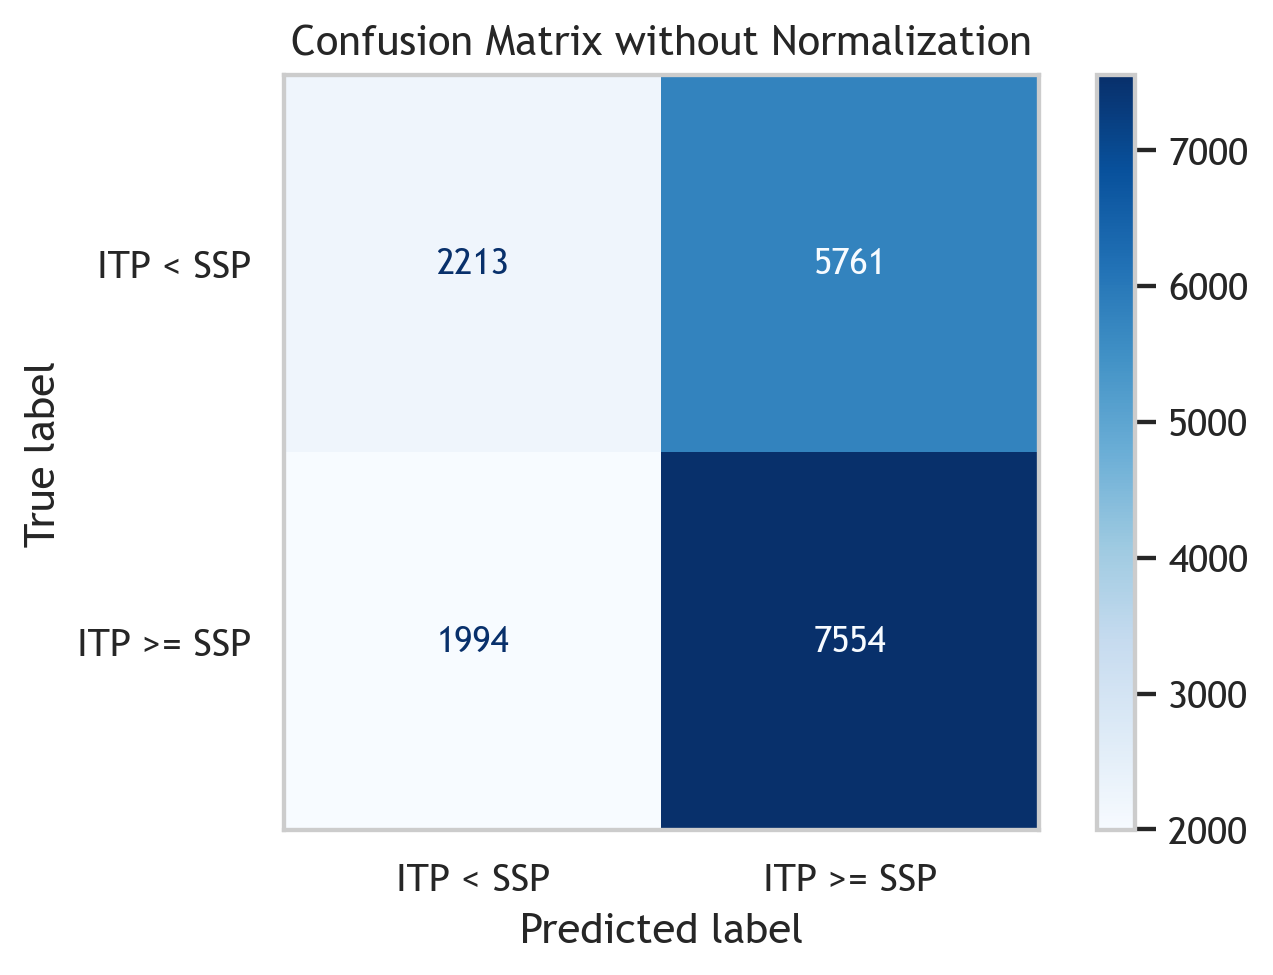

In [ ]:
from sklearn.metrics import plot_confusion_matrix 

disp = plot_confusion_matrix(classifier, X_vali_selected, vali_labels,
                                 display_labels=['ITP < SSP', 'ITP >= SSP'],
                                 cmap=plt.cm.Blues,
                                 values_format = '.2f',
                                 normalize='true')
plt.grid(False)
disp.ax_.set_title('Confusion Matrix with Normalization')

# save the plot
filename = 'confumatrix_2hr_logilasso_ori_lag{}'.format(l) 
plt.savefig(filename+'.png')

plt.show()

disp = plot_confusion_matrix(classifier, X_vali_selected, vali_labels,
                                 display_labels=['ITP < SSP', 'ITP >= SSP'],
                                 cmap=plt.cm.Blues,
                                 values_format = '',
                                 normalize=None)
plt.grid(False)
disp.ax_.set_title('Confusion Matrix without Normalization')

# save the plot
filename = 'confumatrix_2hr_logilasso_norm_lag{}'.format(l) 
plt.savefig(filename+'.png')

plt.show()

In [ ]:
print('Run time(s)', str(datetime.timedelta(seconds=total)))
print() # create new line

# summarize scores
print('Baseline: ROC AUC=%.3f' % (ns_auc))
print('Logistic with Lasso: ROC AUC=%.3f' % (lr_auc))
print()
## Confusion Matrix

from sklearn.metrics import confusion_matrix
print('Confusion matrix', confusion_matrix(vali_labels, logi_pred))

# Accuracy
from sklearn.metrics import accuracy_score
print('Accuracy score',accuracy_score(vali_labels, logi_pred))

# Recall
from sklearn.metrics import recall_score
print('Recall score', recall_score(vali_labels, logi_pred, average=None))

# Precision
from sklearn.metrics import precision_score
print('Precision score',precision_score(vali_labels, logi_pred, average=None))

# F1 score
from sklearn.metrics import f1_score
print('F1 score', f1_score(vali_labels, logi_pred))
# The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. 
# The formula for the F1 score is: F1 = 2 * (precision * recall) / (precision + recall)

Run time(s) 0:00:11.550390

Baseline: ROC AUC=0.500
Logistic with Lasso: ROC AUC=0.564

Confusion matrix [[2213 5761]
 [1994 7554]]
Accuracy score 0.5574135372674353
Recall score [0.27752696 0.79116045]
Precision score [0.52602805 0.56733008]
F1 score 0.6608056685474347
